In [1]:
# Transforming the ALFRED dataset
from utils import *

ALFRED_JSON_PATTERN = '../datasets/alfred/data/ALFRED_json_2.1.0/valid_unseen/*/*/*.json' 
train_dataset = load_next_alfred_data(ALFRED_JSON_PATTERN)
print('train dataset size: ', len(train_dataset))
print('%3f kb' % (sys.getsizeof(train_dataset) / 1024.0))


100%|██████████| 255/255 [00:03<00:00, 66.53it/s]

train dataset size:  255
2.171875 kb


In [ ]:
# OPTIONAL: Filter dataset

import random

dataset25 = filtered_dataset_copy(train_dataset, 'FloorPlan25')
# A little random sample for testing
print('dataset samples: ', len(dataset25))
for i in range(1):
    print('*' * 20)
    example = dataset25[0] #random.choice(dataset25)
    #print(example[1]['floor_plan'])
    #print(example[1]['object_poses'])
    print(example[1]['task_id'])
    for j in example[0]:
        print('-' * 20)
        print(j['task_desc'])
        print(j['instructions'])

In [2]:
from models import *

m = CosineModel()
class T:
    x = torch.randn(4,10)
    edge_index = torch.randn(2, 4)

t = T()
m(t, torch.randn(10,10))


(tensor([ 1.4759, -0.2650, -0.4139,  0.5790]),
 [tensor(3),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(2),
  tensor(1),
  tensor(1),
  tensor(2),
  tensor(3)])

In [7]:
# import ai2thor
import ai2thor.controller
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import torchtext
import spacy
import pandas as pd
import json, pickle, time
from tqdm.notebook import trange, tqdm

print(ai2thor.__version__)
controller = ai2thor.controller.Controller('Very Low', False, True)
controller.start()
controller.step(dict(action='Initialize', grid_size=0.5, headless=True, visibilityDistance=0.1, fieldOfView=90.0, renderObjectImage=False, renderClassImage=False, renderDepthImage=False))

from thor_environment import *

import os
import random
import networkx as nx
import matplotlib.pyplot as plt
import copy

# Seed for reproduceability
np.random.seed(42)
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using: ',device)

# Experiment parameters
debug_instructions = False
debug_scores = False
debug_log = True
subset = train_dataset[53:54]
model = CosineModel().to(device)
nlp = spacy.load('en_core_web_sm')

# The test is for a multiple instructions intended to be executed over multiple timesteps of length 1
max_timesteps = 1 # TODO: Consider increasing to increase performance, niko used 10 i think.
reward = []
used_timesteps = []
trajectory_success = []
instruction_success = []
task_number = 0

# Experiment Log
if debug_log:
    debug_log_file = open('[BI-S] baseline_debug_log.tsv', 'w')
    debug_log_file.write("scene \t instruction \t expected_object \t expected_affordance \t actual_object \t actual_affordance \t success\n")

# run for each instruction in a task
for task in subset:
    trajectories, scene = task
    
    scene_name = "FloorPlan%d" % scene['scene_num']
    task_id = scene['task_id']
    object_poses = scene['object_poses']
    object_toggles = scene['object_toggles']
    dirty_and_empty = scene['dirty_and_empty']
    init_action = scene['init_action']
    
    # ALFRED has a custom initialised scene for each task
    # This is expensive, every task requires new initalisations and therefore new explorations
    environment_file = "../saved_environments/{}_{}.gz".format(scene_name, task_id)
    
    episode = {'log_probs':[], 'rewards':[], 'timesteps':0, 'entropy':[]}
    done = False
    t = 0
    task_number += 1
    print(" --- %d / %d --- %s" % (task_number, len(subset), task_id))
    
    for traj_idx, traj in enumerate(trajectories):
        # Each trajectory in a task uses the same environment but must be reset
        # each trajectory.
        controller.reset(scene_name)
        env = ThorEnvironment(controller=controller)
        event = controller.step(dict(action='Pass'))
        
        if os.path.isfile(environment_file):
            # load file, if exists
            thor_restore(controller, init_action, object_poses, object_toggles, dirty_and_empty)
            print('Loading environment...')
            env.graph = env.graph.from_pickle(environment_file)
            if not hasattr(env.graph, 'robot_node'):
                env.graph.setup()
            print('Done')
        else:
            # explore and save
            thor_restore(controller, init_action, object_poses, object_toggles, dirty_and_empty)
            print('Exploring environment...')
            env.explore_environment()
            env.graph.setup()
            print('Saving environment...')
            env.graph.to_pickle(environment_file)
            print('Done')
        
        print('Graph size (nodes): ', len(env.graph))
        #draw_graph(env.graph)
        complete_trajectory = True
        
        if not valid_trajectory(env, traj):
            print('[CHECK] Invalid trajectory. Skipping...')
            continue
        else:
            print('[CHECK] Valid Trajectory!')
        
        if debug_instructions:
            print("Task Trajectory: %d / %d (%d instructions)" % (traj_idx+1, len(trajectories), len(traj['instructions'])))
            print('High level objective: %s | Task Num: %s' % (traj['task_desc'], task_id))
        
        for inst_idx, instruction in enumerate(traj['instructions']):
            if debug_instructions:
                print('-----> Instruction %d / %d' % (inst_idx + 1, len(traj['instructions'])))            
            
            target_object = instruction['argument_1']
            if not instruction['argument_2'] == '<unk>': # ALFRED PutObject actions receptical as argument_2. 
                target_object = instruction['argument_2']
            
            target_affordance = instruction['action']
            print(instruction)
            
            if debug_instructions:
                print("Target affordance: %s -> %s\nTarget Instruction: %s" % (instruction['action'], target_object, ' '.join(instruction['instruction'])))
            pos_tags = nlp(' '.join(instruction['instruction']))
            #print([(t.text, t.tag_) for t in pos_tags])
            
            verbs = list(filter(lambda x: x.tag_[0] == 'V', pos_tags))
            verb_embedding = [env.graph.word2vec(word.lemma_) for word in verbs]
            
            nouns = list(filter(lambda x: x.tag_[0] == 'N', pos_tags))
            noun_embedding = [env.graph.word2vec(word.lemma_) for word in nouns]
            
            #target_embedding = [env.graph.word2vec(word.lower()) for word in instruction['instruction']]

            #done = False
            for timestep in range(max_timesteps):
                
                env.graph.to_torch_graph()
                
                # Target nouns to find relevant objects
                noun_target = torch.tensor(noun_embedding, dtype=torch.float).to(device)
                noun_logits, _ = model(env.graph._torch_graph, noun_target)
                obj_mask = torch.tensor(env.graph._torch_affordance_mask==1, dtype=torch.bool).to(device)
                noun_logits[obj_mask] = -1000
                relevant_objects = torch.argsort(noun_logits, descending=True)[:1]
                relevant_affordance_mask = [] # Only affordances that are successors of the relevant objects
                for rel_obj in relevant_objects:
                    relevant_affordance_mask.extend(env.graph.get_affordances(env.graph.from_torch_id(rel_obj.item())))
                #print([env.graph.nodes[env.graph.from_torch_id(r)]['affordance'] for r in relevant_affordance_mask])
                print(f"found target nouns:{nouns} relevant nodes: {[env.graph.nodes[env.graph.from_torch_id(n.item())]['obj'] for n in relevant_objects]}")
                
                # Target verbs to find relevant affordances
                verb_target = torch.tensor(verb_embedding, dtype=torch.float).to(device)
                verb_logits, _ = model(env.graph._torch_graph, verb_target)
                
                # we only care about the affordance nodes, so set the logits of all other nodes to something very small
                affordance_mask = torch.tensor(env.graph._torch_affordance_mask==0, dtype=torch.bool).to(device)
                verb_logits[affordance_mask] = -1000
                verb_logits[relevant_affordance_mask] += 1000 # Markup the relevant object's affordances
                print(f"found target verbs:{verbs} relevant verbs: {[env.graph.nodes[env.graph.from_torch_id(n.item())]['affordance'] for n in torch.argsort(verb_logits, descending=True)[:5]]}")
                
                # sample an action from the output of the model
                action = torch.argmax(verb_logits)
                affordance = env.graph.from_torch_id(action.item())
                
                correct_affordance = False
                actual_affordance = env.graph.nodes[affordance]['affordance']
                
                if actual_affordance == normalize_action_name(target_affordance):
                    correct_affordance = True
                
                r = 0.0
                succ, pred = env.graph.get_related_objects(affordance)
                
                correct_object = False
                actual_object = None
                
                if not pred is None:
                    for n in pred:
                        actual_object = env.graph.nodes[n]['obj']
                        if actual_object == target_object:
                            if correct_affordance:
                                r = 1.0
                                #done = True
                                correct_object = True
                                env.step(action.item()) # An Action is an affordance in the graph
                                # TODO: If action cannot be executed, break loop and print error. 
                                break
                
                print("Target: %s -> %s \t Actual: %s -> %s [%s]" % (normalize_action_name(target_affordance), target_object, actual_affordance, actual_object, correct_affordance and correct_object))
                #assert False

                if correct_affordance and correct_object:
                    instruction_success.append((1.0, normalize_action_name(target_affordance), len(instruction['instruction'])))
                else:
                    complete_trajectory = False
                    instruction_success.append((0.0, normalize_action_name(target_affordance), len(instruction['instruction'])))
                
                if debug_log:
                    debug_log_file.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (scene_name, ' '.join(instruction['instruction']), normalize_action_name(target_affordance), target_object, actual_affordance, actual_object, correct_object and correct_affordance))
                
                episode['rewards'].append(r)
                episode['timesteps'] = t
        
        if complete_trajectory:
            trajectory_success.append(1.0)
        else:
            trajectory_success.append(0.0)
    
    # === end of an episode ===
    used_timesteps.append(t)
    
    reward.append(np.sum(episode['rewards']))

if debug_log:
    debug_log_file.close()

2.1.0
Using:  cpu
 --- 1 / 1 --- trial_T20190908_091747_866951
Loading environment...
Done
Graph size (nodes):  375
[CHECK] Valid Trajectory!
{'instruction': ['walk', 'around', 'the', 'center', 'table', 'to', 'face', 'the', 'right', 'side', 'of', 'the', 'sink'], 'action': 'GotoLocation', 'argument_1': 'countertop', 'argument_2': '<unk>'}
found target nouns:[center, table, side, sink] relevant nodes: ['sinkbasin']
found target verbs:[walk, face] relevant verbs: ['go', 'put', 'go', 'go', 'go']
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
{'instruction': ['pick', 'up', 'the', 'bread', 'on', 'the', 'counter', 'to', 'the', 'right', 'of', 'the', 'sink'], 'action': 'PickupObject', 'argument_1': 'bread', 'argument_2': '<unk>'}
found target nouns:[bread, counter, right, sink] relevant nodes: ['sink']
found target verbs:[pick] relevant verbs: ['go', 'pick', 'pick', 'pick', 'pick']
Target: pick -> bread 	 Actual: go -> sink [False]
{'instruction': ['turn', 'around', 'and', 'step', '

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


found target nouns:[step, right, counter, right, fridge] relevant nodes: ['fridge']
found target verbs:[take, face] relevant verbs: ['put', 'go', 'close', 'open', 'put']
Target: go -> countertop 	 Actual: put -> fridge [False]
{'instruction': ['place', 'the', 'bread', 'on', 'the', 'counter'], 'action': 'PutObject', 'argument_1': 'bread', 'argument_2': 'countertop'}
found target nouns:[bread, counter] relevant nodes: ['bread']
found target verbs:[place] relevant verbs: ['go', 'heat', 'pick', 'cool', 'slice']
Target: put -> countertop 	 Actual: go -> bread [False]
Loading environment...
Done
Graph size (nodes):  375
[CHECK] Valid Trajectory!
{'instruction': ['turn', 'around', 'walk', 'to', 'the', 'fridge', 'turn', 'left', 'and', 'walk', 'to', 'the', 'counter'], 'action': 'GotoLocation', 'argument_1': 'countertop', 'argument_2': '<unk>'}
found target nouns:[walk, fridge, counter] relevant nodes: ['fridge']
found target verbs:[turn, turn, walk] relevant verbs: ['go', 'put', 'close', 'open'

Visualise Baseline Performance
-----------------------------

Tasks:  255
Trajectories:  821
Instructions:  5140
Trajectory Successes:  1.0
Trajectory Failures:  820.0
Failure:  {'go': 1720.0, 'pick': 691.0, 'heat': 108.0, 'put': 747.0, 'cool': 93.0, 'toggle': 173.0, 'clean': 109.0, 'slice': 29.0}
Success:  {'go': 731.0, 'pick': 425.0, 'heat': 28.0, 'put': 190.0, 'cool': 16.0, 'toggle': 0.0, 'clean': 4.0, 'slice': 76.0}
[[ 731.  425.   28.  190.   16.    0.    4.   76.]
 [1720.  691.  108.  747.   93.  173.  109.   29.]]


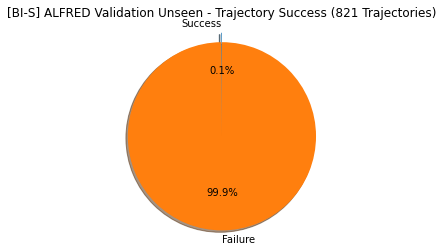

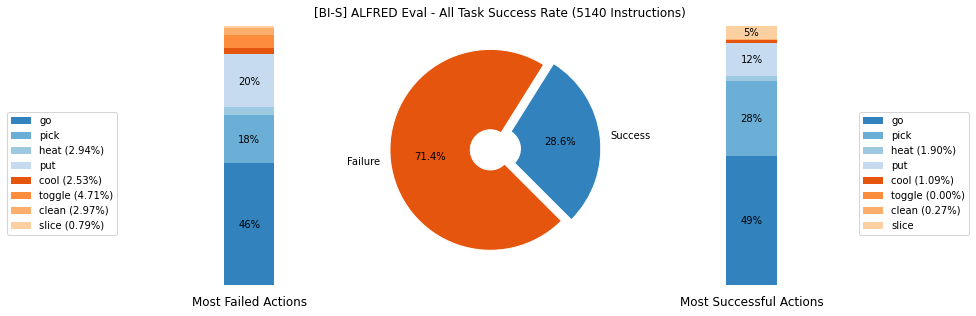

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

success = instruction_success

print("Tasks: ", len(subset))
print("Trajectories: ", len(trajectory_success))
print("Instructions: ", len(instruction_success))

succ_sum = 0
for i in success:
    succ_sum += i[0]

save_figures = True

# Trajectory pie chart
traj_success_count = sum(trajectory_success)
traj_fail_count = len(trajectory_success) - traj_success_count
print('Trajectory Successes: ', traj_success_count)
print('Trajectory Failures: ', traj_fail_count)
fig1, ax1 = plt.subplots()
ax1.pie([traj_success_count, traj_fail_count], explode=(0.0,0.1), labels=['Success','Failure'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(title='[BI-S] ALFRED Validation Unseen - Trajectory Success (%d Trajectories)' % len(trajectory_success))
if save_figures:
    plt.savefig('[BI-S] ALFRED Validation Unseen - Trajectory Success.png', dpi=300, bbox_inches='tight')

# Instruction pie and bar chart
action_failure = {}
action_success = {}
task_instruction_lengths = {}

for i in success:
    if not i[1] in action_success:
        action_success[i[1]] = 0.0
    if not i[1] in action_failure:
        action_failure[i[1]] = 0.0
    if not i[1] in task_instruction_lengths:
        task_instruction_lengths[i[1]] = []
    if i[0] == 1.0:
        action_success[i[1]] += 1.0
    else:
        action_failure[i[1]] += 1.0
    task_instruction_lengths[i[1]].append(i[2])

action_list = list(action_success.keys())

print('Failure: ', action_failure)
print('Success: ', action_success)

# make figure and assign axis objects
fig = plt.figure(figsize=(9+4.5, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
fig.subplots_adjust(wspace=0)

size = 0.2
vals = np.array([list(action_success.values()), list(action_failure.values())])
print(vals)

cmap = plt.get_cmap("tab20c")
pie_colors = cmap(np.arange(3)*4)
bar_colors = cmap(np.arange(8))

# bar chart parameters
xpos = 0
bottom = 0
ratios = [i / np.sum(vals[1]) for i in vals[1]] #Failure values
width = .2
fail_labels = action_list[:]

for j in range(len(ratios)):
    height = ratios[j]
    ax1.bar(xpos, height, width, bottom=bottom, color=bar_colors[j], ecolor='w')
    ypos = bottom + ax1.patches[j].get_height() / 2.
    bottom += height
    if ratios[j] > 0.1:
        ax1.text(xpos, ypos - 0.015, "%d%%" % (ax1.patches[j].get_height() * 100),
                 ha='center')
    else:
        fail_labels[j] = "{} ({:.2f}%)".format(fail_labels[j], ratios[j] * 100.0)

ax1.set_title('Most Failed Actions', y=-0.1)
ax1.legend(fail_labels, bbox_to_anchor=(0,0.25), loc="lower left",  bbox_transform=fig.transFigure)
ax1.axis('off')
ax1.set_xlim(- 2.5 * width, 2.5 * width)

# pie chart parameters
ax2.pie(vals.sum(axis=1), explode=(0.0,0.1), labels=('Success', 'Failure'), autopct='%1.1f%%',
        shadow=False, startangle=-45, radius=1., colors=pie_colors, wedgeprops=dict(width=0.8, edgecolor='w'))

ax2.set(title='[BI-S] ALFRED Eval - All Task Success Rate (%d Instructions)' % len(success))

# bar chart parameters
xpos = 0
bottom = 0
ratios = [i / succ_sum for i in vals[0]] #Success values
width = .2

for j in range(len(ratios)):
    height = ratios[j]
    ax3.bar(xpos, height, width, bottom=bottom, color=bar_colors[j], ecolor='w')
    ypos = bottom + ax3.patches[j].get_height() / 2.
    bottom += height
    if ratios[j] > 0.05:
        ax3.text(xpos, ypos - 0.015, "%d%%" % (ax3.patches[j].get_height() * 100),
                 ha='center')
    else:
        action_list[j] = "{} ({:.2f}%)".format(action_list[j], ratios[j] * 100.0)

ax3.set_title('Most Successful Actions', y=-0.1)
ax3.legend(action_list, bbox_to_anchor=(1,0.25), loc="lower right",  bbox_transform=fig.transFigure)
ax3.axis('off')
ax3.set_xlim(- 2.5 * width, 2.5 * width)

#plt.tight_layout()
if save_figures:
    plt.savefig('[BI-S] ALFRED_Eval-instructions-success.png', dpi=300, bbox_inches='tight')

In [ ]:
# Instruction Length Bar Chart
# Instruction length vs task success
plt.rcdefaults()
fig, ax = plt.subplots()

action_success_sorted = dict(sorted(action_success.items(), key=lambda item: item[1], reverse=True))
task_lengths_sorted = {}
for k in action_success_sorted.keys():
    task_lengths_sorted[k] = np.mean(task_instruction_lengths[k])

tasks = action_success_sorted.keys() # In order of success
y_pos = np.arange(len(tasks))
tasks_success = task_lengths_sorted.values()

ax.barh(y_pos, tasks_success, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(tasks)
ax.invert_yaxis()  # labels read top-to-bottom
rects = ax.patches
labels = ["%.2f%%" % ((i/succ_sum)*100.0) for i in action_success_sorted.values()]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + 0.55, label,
            ha='center', va='bottom')
ax.set_xlabel('Average Instruction Length')
ax.set_title('Comparing instruction length to task success')
if save_figures:
    plt.savefig('Comparing instruction length to task success.png', dpi=300, bbox_inches='tight')

In [ ]:
import pandas as pd
import cv2
import pathlib

#=========================================================
#import torchtext

# Load FastText word vectors
#fast_text = torchtext.vocab.FastText(cache='../.vector_cache')

# Load ALFRED training data using torchtext
import torchtext.data as data

#  Basic english normalisation, lowers and seperates grammar
INSTRUCTION = data.Field(tokenize='basic_english', lower=True,
                         init_token='<sos>',
                         eos_token='<eos>',)
ACTION = data.Field(is_target=True)
ACTION_ARGUMENT_1 = data.Field(tokenize='basic_english',is_target=True)
ACTION_ARGUMENT_2 = data.Field(tokenize='basic_english',is_target=True)

ALFRED_DATA_ROOT = '../honours_research_repo/'
ALFRED_TRAIN_INSTRUCTION_TSV_FILENAME = ALFRED_DATA_ROOT + 'ALFRED_Train_InstActionArgs.tsv'
ALFRED_VALIDATION_INSTRUCTION_TSV_FILENAME = ALFRED_DATA_ROOT + 'ALFRED_Validation_InstActionArgs.tsv'
ALFRED_TEST_INSTRUCTION_TSV_FILENAME = ALFRED_DATA_ROOT + 'ALFRED_Test_InstActionArgs.tsv'

def filter_action(example):
    if example.action[0] == 'PickupObject':
        return True
    else:
        return False

train, val, test = data.TabularDataset.splits(
    path='', 
    train=ALFRED_TRAIN_INSTRUCTION_TSV_FILENAME,
    validation=ALFRED_VALIDATION_INSTRUCTION_TSV_FILENAME,
    test=ALFRED_TEST_INSTRUCTION_TSV_FILENAME, format='tsv',
    fields=[('trajectory_number', None),
            ('task_description', None),
            ('instruction_number', None),
            ('instruction', INSTRUCTION),
            ('action', ACTION),
            ('action_argument_1', ACTION_ARGUMENT_1),
            ('action_argument_2', ACTION_ARGUMENT_2)
           ], 
    filter_pred=filter_action)

INSTRUCTION.build_vocab(train,vectors=__word_vec__) #'fasttext.en.300d')
ACTION.build_vocab(train)
ACTION_ARGUMENT_1.build_vocab(train,vectors=__word_vec__)
ACTION_ARGUMENT_2.build_vocab(train,vectors=__word_vec__)
#=========================================================